# Libraries
if you are in Google Colab, run the cell !pip install pycaret[full] before pycaret import. However, <b>we strongly recommend to run this notebook in a local environment with Python 3.8, 3.9 or 3.10</b> because PyCaret 3.0.4 is only compatible with these Python versions.

In [1]:
import numpy as np
import pandas as pd
from pycaret.utils import version
from pycaret.regression import *
version()

'3.0.4'

# Preprocess
Load the data and convert some columns to meet the PyCaret type requirements. See the comments below of each line of code.

In [2]:
# data load
dataset = pd.read_csv('dataset_temporalQUARTER.csv', sep=';')
#dataset = pd.read_csv('/content/drive/MyDrive/Projeto Difusão FV/dataset_temporalQUARTER.csv', sep=';')

In [3]:
# Saving the original data for future intepretation
original_dataset = dataset.copy()

# Useless variable for difusion prediction
dataset.drop(columns=['City_Cod', 'City_Name'], inplace=True)

# Converter a coluna "Trimestre" para formato de data (Period)
dataset['Quarter'] = pd.PeriodIndex(dataset['Quarter'], freq='Q')
dataset['Quarter'] = dataset['Quarter'].dt.to_timestamp()
dataset['GDP'] = dataset['GDP'].astype('float')

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90129 entries, 0 to 90128
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Quarter                          90129 non-null  datetime64[ns]
 1   Installed_power                  90129 non-null  float64       
 2   Electricity Tariff               90129 non-null  float64       
 3   Demographic_density              90129 non-null  float64       
 4   Fleet                            90129 non-null  int64         
 5   Average_minimum_wage             90129 non-null  float64       
 6   Number_employees                 90129 non-null  int64         
 7   Number_companies                 90129 non-null  int64         
 8   GDP                              90129 non-null  float64       
 9   Population                       90129 non-null  float64       
 10  Area                             90129 non-null  float64  

In [5]:
dataset

,Quarter,Installed_power,Electricity Tariff,Demographic_density,Fleet,Average_minimum_wage,Number_employees,Number_companies,GDP,Population,...,Income HDI,College education,Irradiance,Number of households,Cities verticalization,Households in rural area,Home ownership,Home rented,Residents per household,Households with 3 more salaries
0,2018-07-01,6.50,685.603639,3.28,16100,1.8,3271,521,21538.40,23167.0,...,0.657,0.036,4635,7270,0.0035,0.41,5364,822,3.1,236
1,2019-04-01,8.00,685.603639,3.25,16100,1.8,3023,459,21600.74,22945.0,...,0.657,0.036,4635,7270,0.0035,0.41,5364,822,3.1,236
2,2019-10-01,6.69,685.603639,3.25,16100,1.8,3023,459,21600.74,22945.0,...,0.657,0.036,4635,7270,0.0035,0.41,5364,822,3.1,236
3,2020-01-01,248.00,665.434191,3.22,16100,1.8,3023,459,21968.76,22728.0,...,0.657,0.036,4635,7270,0.0035,0.41,5364,822,3.1,236
4,2020-04-01,61.74,665.434191,3.22,16100,1.8,3023,459,21968.76,22728.0,...,0.657,0.036,4635,7270,0.0035,0.41,5364,822,3.1,236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90124,2022-04-01,22790.02,720.872001,537.14,1982829,5.3,1392701,101020,83405.82,3094325.0,...,0.863,0.124,5252,774021,0.2644,0.03,457216,235040,4.0,228274
90125,2022-07-01,28838.69,720.872001,537.14,1982829,5.3,1392701,101020,83405.82,3094325.0,...,0.863,0.124,5252,774021,0.2644,0.03,457216,235040,4.0,228274
90126,2022-10-01,26026.34,720.872001,537.14,1982829,5.3,1392701,101020,83405.82,3094325.0,...,0.863,0.124,5252,774021,0.2644,0.03,457216,235040,4.0,228274
90127,2023-01-01,30909.10,720.872001,537.14,1982829,5.3,1392701,101020,83405.82,3094325.0,...,0.863,0.124,5252,774021,0.2644,0.03,457216,235040,4.0,228274


In [6]:
# Sort the instances by Quarter to guarantee the time series
dataset.sort_values(by=['Quarter'], inplace=True)
dataset.reset_index(inplace=True, drop=True)
#dataset['Series'] = np.arange(1,len(dataset)+1)

<h3>Here are some data description to understand the response variable amount "Installed Power" per year</h3>


In [7]:
description = dataset.copy()

description['Year'] = description['Quarter'].dt.year
installedPower_byYear = description.groupby('Year')['Installed_power'].sum()

installedPower_byYear = pd.DataFrame({'total_Installed_Power': installedPower_byYear})
installedPower_byYear

,total_Installed_Power
Year,
2012,664.42
2013,1459.12
2014,2784.50
2015,14492.91
2016,64331.37
2017,157661.22
2018,455860.59
2019,1631052.70
2020,2927441.22


We can see the amount the intalled power is big from 2019. So, it is a good experiment to perform filtering only 2019 and further.

In [8]:
dataset_20192023 = dataset[(dataset['Quarter'] >= '2019Q1')]
len(dataset_20192023)

76375

Other interesting experiment can be train the model from 2019 to end of 2022 and then try to predict the two quarters of 2023. For this end, we need to separate the data into train and test.

In [9]:
train = dataset[(dataset['Quarter'] >= '2019Q1') & (dataset['Quarter'] <= '2022Q2')]
test = dataset[dataset['Quarter'] >= '2023Q1']

print("the train has ", len(train), "instances")
print("the test has ", len(test), "instances")

the train has  57890 instances
the test has  8550 instances


<h3>Here are some data variations from the descriptive analysis above</h3>

<ul>
    <li><b style="color:red">dataset</b> = original data <b style="color:red">(90,129 rows)</b> 2012Q1 to 2023Q2
    <li><b style="color:blue">dataset_20192023</b> = filtered data  <b style="color:blue">(76,375 rows)</b> 2019Q1 to 2023Q2
    <li><b style="color:green">train, test</b> = filtered data  <b style="color:green">(57,890, 8,550 rows)</b> 2019Q1 to 2022Q4 and 2023Q1 to 2023Q2
</ul>


# Experiment 01
all the data and withou fixing the test set. All the cross-validation process is done by Pycaret with a time series premisse, i.e., it does not hurt the temporal sequence while performing the validation.

In [10]:
exp1 = setup(
    data = dataset,
    target = 'Installed_power',
    fold_strategy = 'timeseries',
    session_id = 123,
    data_split_shuffle = False,
    fold=10,
    ignore_features = ['Quarter'], #once data has been sorted by quarter, we can ignore it
)

best1 = compare_models(turbo=False, exclude=['kr'])

,Description,Value
0,Session id,123
1,Target,Installed_power
2,Target type,Regression
3,Original data shape,"(90129, 23)"
4,Transformed data shape,"(90129, 22)"
5,Transformed train set shape,"(63090, 22)"
6,Transformed test set shape,"(27039, 22)"
7,Ignore features,1
8,Numeric features,21
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,103.1008,180706.6706,381.7870,0.4377,1.1400,2.3358,12.8220
xgboost,Extreme Gradient Boosting,107.3466,183085.2074,385.1555,0.4239,1.2027,2.5416,1.3880
et,Extra Trees Regressor,103.4900,183260.7145,386.4645,0.4235,1.1858,2.1349,4.0090
catboost,CatBoost Regressor,107.3910,184796.5372,387.7510,0.4145,1.1884,2.4162,4.4660
lightgbm,Light Gradient Boosting Machine,110.2110,193924.3961,396.8196,0.4010,1.1951,2.4450,0.8830
knn,K Neighbors Regressor,108.1580,196707.4293,398.1442,0.3931,1.1808,1.9051,1.6350
gbr,Gradient Boosting Regressor,120.7632,226632.6736,427.5439,0.3312,1.2242,2.5520,3.3440
dt,Decision Tree Regressor,112.6440,202556.0955,412.2263,0.3273,1.3218,3.8478,0.7970
ada,AdaBoost Regressor,184.2085,270127.8575,476.9871,0.1718,1.7173,8.6115,0.7600
lar,Least Angle Regression,143.1448,323422.7398,510.4424,0.1151,1.3695,3.0304,0.7180


Processing:   0%|          | 0/105 [00:00<?, ?it/s]

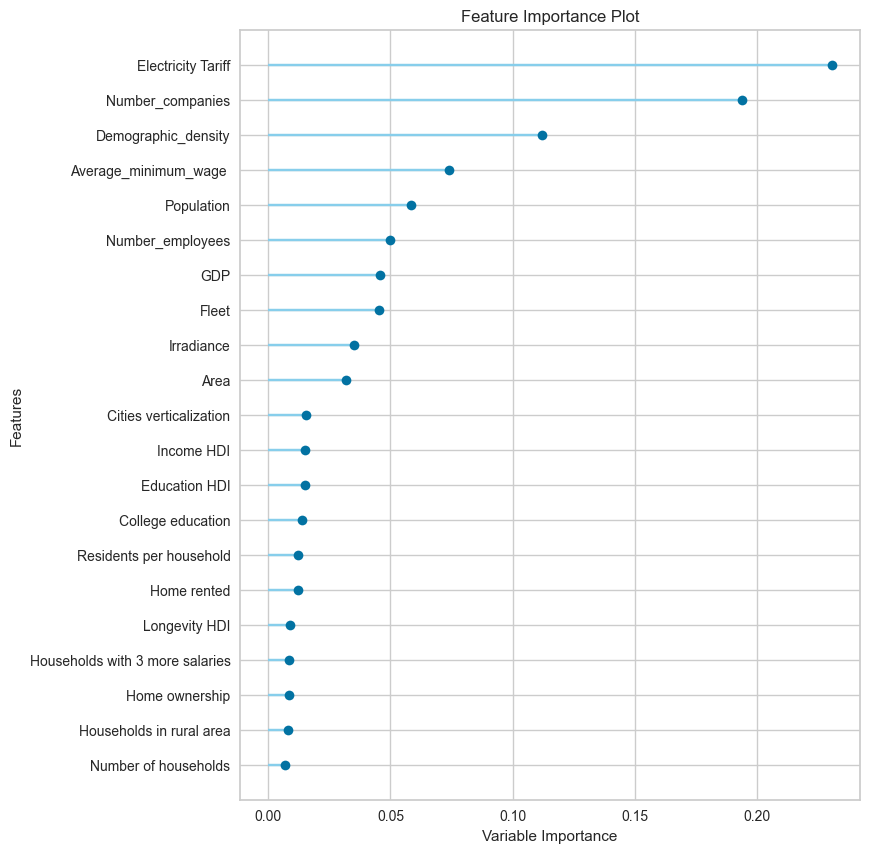

In [11]:
plot_model(best1, 'feature_all')

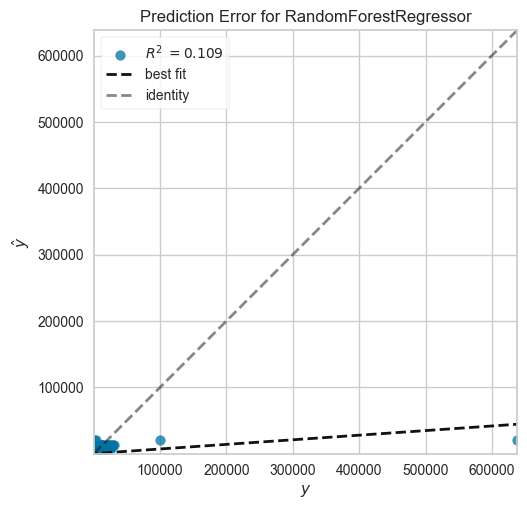

In [12]:
plot_model(best1, 'error')

# Experiment 02
Filtered 2019-2023 data and <b>without fixing</b> the test set. All the cross-validation process is done by Pycaret with a time series premisse, i.e., it does not hurt the temporal sequence while performing the validation.

In [13]:
exp2 = setup(
    data = dataset_20192023,
    target = 'Installed_power',
    fold_strategy = 'timeseries',
    session_id = 123,
    data_split_shuffle = False,
    fold=10,
    ignore_features = ['Quarter'], #once data has been sorted by quarter, we can ignore it
)

best2 = compare_models(turbo=False, exclude=['kr'])

,Description,Value
0,Session id,123
1,Target,Installed_power
2,Target type,Regression
3,Original data shape,"(76375, 23)"
4,Transformed data shape,"(76375, 22)"
5,Transformed train set shape,"(53462, 22)"
6,Transformed test set shape,"(22913, 22)"
7,Ignore features,1
8,Numeric features,21
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,111.3766,182850.2930,404.3012,0.6057,1.0334,1.8857,10.1400
lightgbm,Light Gradient Boosting Machine,114.5675,190209.5392,407.9720,0.6057,1.0757,2.1876,0.8240
catboost,CatBoost Regressor,114.4826,189823.1825,411.1611,0.5922,1.0830,2.1673,3.7040
et,Extra Trees Regressor,113.3388,190731.0788,414.1186,0.5839,1.0893,1.7762,3.3550
xgboost,Extreme Gradient Boosting,116.1204,193368.3047,416.7589,0.5774,1.0903,2.1502,1.2360
gbr,Gradient Boosting Regressor,122.6828,218559.1266,435.9646,0.5590,1.1144,2.3633,2.5630
knn,K Neighbors Regressor,116.7388,205519.0633,426.6939,0.5575,1.0587,1.9000,0.8500
dt,Decision Tree Regressor,118.2216,202247.9692,428.8009,0.5486,1.1392,1.8729,0.7430
ada,AdaBoost Regressor,176.5958,254478.0641,477.2312,0.4603,1.5797,6.6453,0.7580
lr,Linear Regression,165.4231,333210.4512,537.0937,0.3384,1.4033,4.0396,0.6550


Processing:   0%|          | 0/105 [00:00<?, ?it/s]

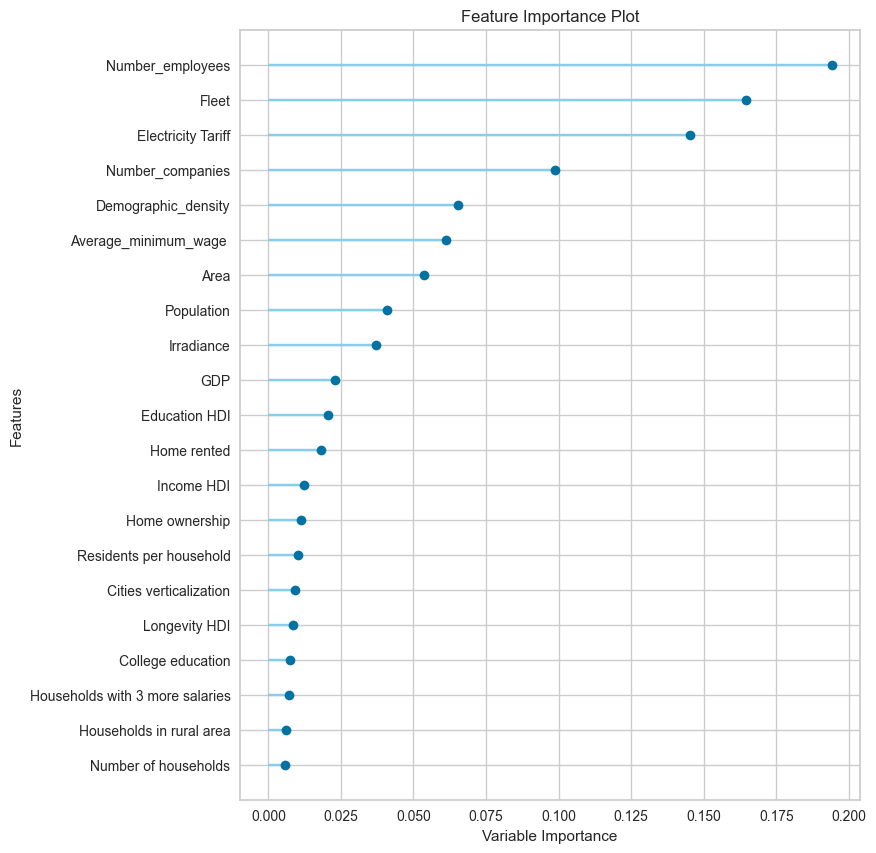

In [14]:
plot_model(best2, 'feature_all')

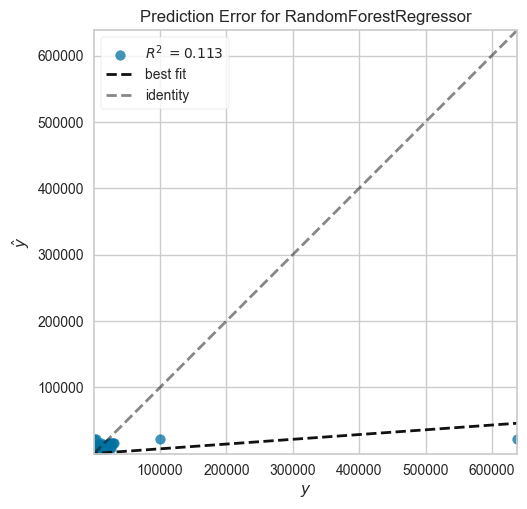

In [15]:
plot_model(best2, 'error')

# Experiment 03
Filtered 2019-2023 data and fixing the test set. All the cross-validation process is done by Pycaret with a time series premisse, i.e., it does not hurt the temporal sequence while performing the validation.

In [16]:
exp3 = setup(
    data = train,
    test_data = test,
    target = 'Installed_power',
    fold_strategy = 'timeseries',
    session_id = 123,
    data_split_shuffle = False,
    fold=10,
    ignore_features = ['Quarter'], #once data has been sorted by quarter, we can ignore it
)

best3 = compare_models(turbo=False, exclude=['kr'])

,Description,Value
0,Session id,123
1,Target,Installed_power
2,Target type,Regression
3,Original data shape,"(66440, 23)"
4,Transformed data shape,"(66440, 22)"
5,Transformed train set shape,"(57890, 22)"
6,Transformed test set shape,"(8550, 22)"
7,Ignore features,1
8,Numeric features,21
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,118.0792,309225.7836,485.9610,0.5920,1.0227,1.8114,11.4540
lightgbm,Light Gradient Boosting Machine,120.8739,335715.9955,496.3715,0.5869,1.0535,2.0368,0.8630
catboost,CatBoost Regressor,120.1144,319108.8247,492.7569,0.5816,1.0654,2.0256,4.0600
xgboost,Extreme Gradient Boosting,122.4522,322450.5328,498.9860,0.5652,1.0793,2.0843,1.4600
et,Extra Trees Regressor,120.8687,322603.5509,500.1190,0.5623,1.0773,1.7149,3.7550
gbr,Gradient Boosting Regressor,130.4623,358267.6043,517.9539,0.5523,1.1048,2.2609,2.6580
knn,K Neighbors Regressor,123.7502,334593.7422,509.0578,0.5469,1.0431,1.8035,0.8170
dt,Decision Tree Regressor,125.2811,333300.2963,513.5594,0.5298,1.1260,1.7692,0.8580
ada,AdaBoost Regressor,179.1345,395390.2245,560.6601,0.4502,1.5160,5.5538,0.7570
lar,Least Angle Regression,181.5472,545555.4042,640.0442,0.3239,1.4329,4.2540,0.7120


Processing:   0%|          | 0/105 [00:00<?, ?it/s]

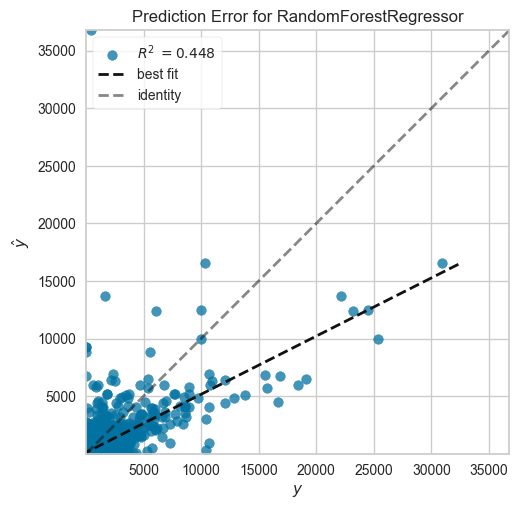

In [17]:
plot_model(best3, 'error')

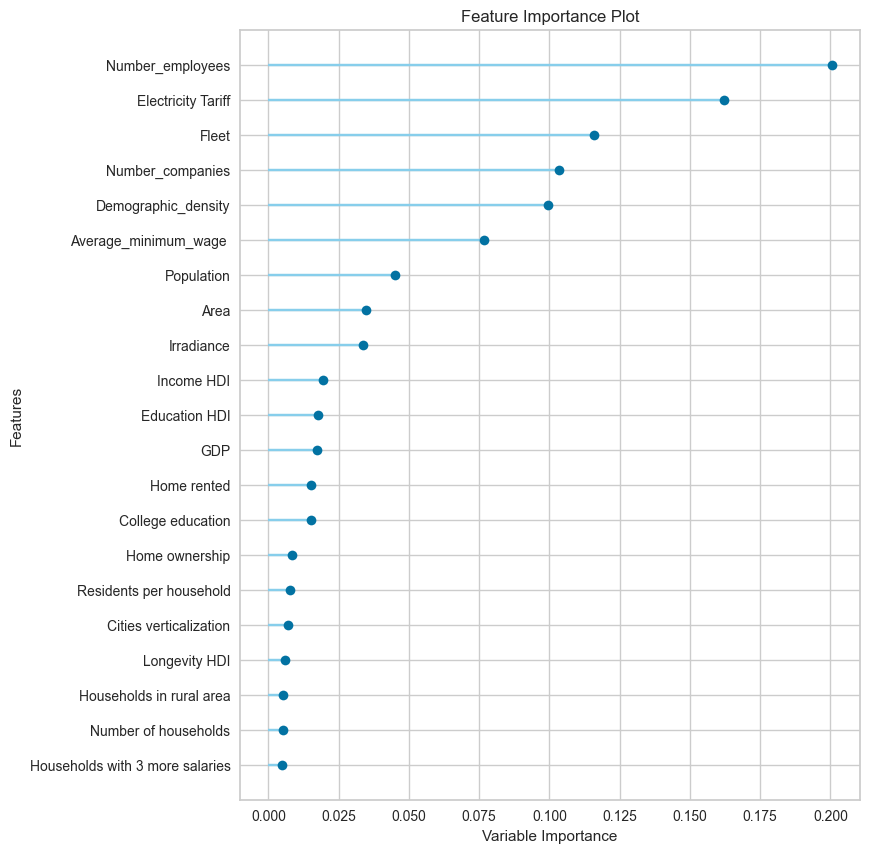

In [18]:
plot_model(best3, 'feature_all')

# Partial interpretation until here
From the above three experiments we can see the second one presents the best RMSE value as well as the best R² value. Therefore, we chose it to continue our analysis. It is worth to mention that we delivered to PyCaret the responsability of controlling the train and test set, i.e., we did not fixed the test set as in experiment 3.


# Experiment 4
Based on this, we try an improvent of experiment 2 considering only the top-10 variable ranked in the feature importance chart.

In [19]:
exp4 = setup(
    data = dataset_20192023,
    target = 'Installed_power',
    fold_strategy = 'timeseries',
    session_id = 123,
    data_split_shuffle = False,
    fold=10,
    ignore_features = ['Quarter', 'Education HDI', 'Home rented', 'Income HDI', 'Home ownership',
                       'Residents per household', 'Cities verticalization', 'Longevity HDI', 'College education',
                      'Households with 3 more salaries', 'Households in rural area', 'Number of households'], #once data has been sorted by quarter, we can ignore it
)

best4 = compare_models(turbo=False, exclude=['kr'])

,Description,Value
0,Session id,123
1,Target,Installed_power
2,Target type,Regression
3,Original data shape,"(76375, 23)"
4,Transformed data shape,"(76375, 11)"
5,Transformed train set shape,"(53462, 11)"
6,Transformed test set shape,"(22913, 11)"
7,Ignore features,12
8,Numeric features,10
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,113.1510,184232.2653,406.2679,0.6013,1.0432,1.9669,6.1580
lightgbm,Light Gradient Boosting Machine,117.0560,193759.9138,412.3015,0.5965,1.0904,2.2969,0.8310
catboost,CatBoost Regressor,115.9755,190533.2164,411.9917,0.5906,1.0917,2.2620,3.0080
et,Extra Trees Regressor,113.8966,190972.4502,414.5385,0.5829,1.0938,1.8517,2.2420
xgboost,Extreme Gradient Boosting,115.7219,193307.2273,416.4567,0.5782,1.0863,2.1520,1.1300
knn,K Neighbors Regressor,117.0147,206002.5781,426.7647,0.5579,1.0601,1.9402,0.6900
gbr,Gradient Boosting Regressor,124.0629,220356.8301,437.2291,0.5563,1.1388,2.5443,1.5980
dt,Decision Tree Regressor,122.0947,208230.0279,434.5011,0.5310,1.1597,2.0025,0.7240
ada,AdaBoost Regressor,175.6550,260686.5930,484.7091,0.4340,1.5511,6.2887,0.7470
lar,Least Angle Regression,177.8916,367255.8178,565.9746,0.2616,1.5031,4.9194,0.6660


Processing:   0%|          | 0/105 [00:00<?, ?it/s]

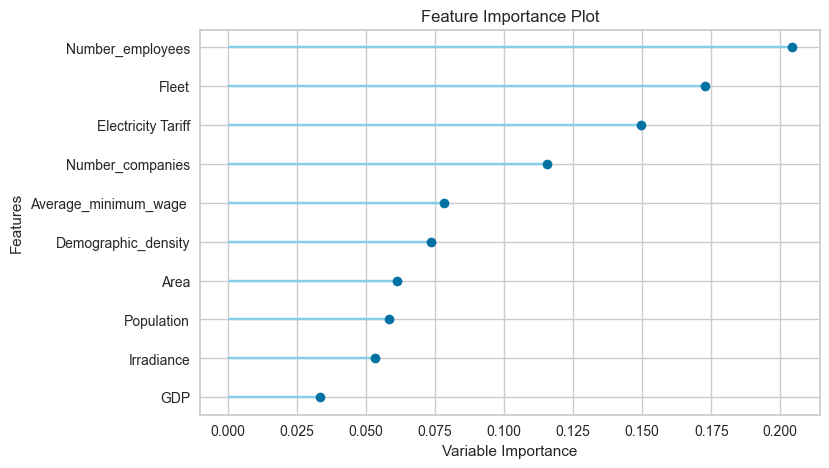

In [20]:
plot_model(best4, 'feature_all')

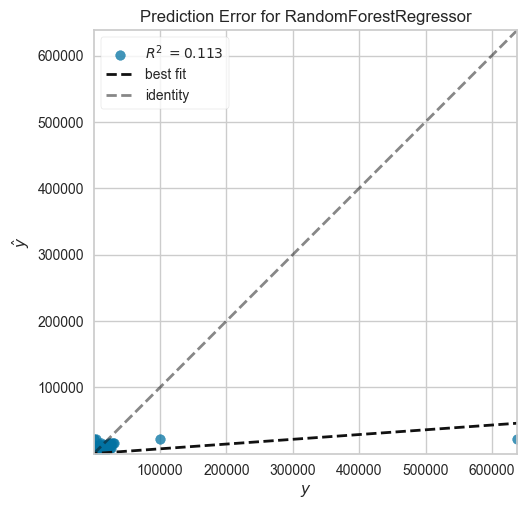

In [21]:
plot_model(best4, 'error')

# Partial interpretation
based on the results of experiment 4 we conclude that removing variables with low contribution does not improve the models. The performance is almost the same with a little increase in RMSE value and an increase in R² which is not desrireble. So, we keep  experiment 2 as the best result.

# Experiment 5
As another attempt trying to improve the experiment 2 performance, we try here to blend models based on the exp2 config.

In [22]:
exp5 = setup(
    data = dataset_20192023,
    target = 'Installed_power',
    fold_strategy = 'timeseries',
    session_id = 123,
    data_split_shuffle = False,
    fold=10,
    ignore_features = ['Quarter'], #once data has been sorted by quarter, we can ignore it
)


# Train the models individually
model_rf = create_model('rf')
model_lightgbm = create_model('lightgbm')
model_catb = create_model('catboost')

# Creating the ensemble based on the selected models
ensemble_model = blend_models(estimator_list=[model_rf, model_lightgbm, model_catb])

,Description,Value
0,Session id,123
1,Target,Installed_power
2,Target type,Regression
3,Original data shape,"(76375, 23)"
4,Transformed data shape,"(76375, 22)"
5,Transformed train set shape,"(53462, 22)"
6,Transformed test set shape,"(22913, 22)"
7,Ignore features,1
8,Numeric features,21
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,84.2251,72708.4046,269.6450,0.4783,1.1493,2.2497
1,107.1432,124894.7156,353.4045,0.4657,1.1372,2.1396
2,97.1538,93698.9196,306.1028,0.6149,1.1120,2.3055
3,89.7850,101555.7795,318.6782,0.5826,1.0764,2.0094
4,104.7386,143209.5785,378.4304,0.6232,1.0596,1.9230
5,122.9952,124113.4687,352.2974,0.6389,1.1094,2.5710
6,102.4495,106059.2449,325.6674,0.6970,0.9856,1.6974
7,120.8118,151448.9923,389.1645,0.7461,0.9227,1.3146
8,141.3546,463611.3716,680.8901,0.5528,0.9073,1.5862


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,83.8211,69380.4800,263.4017,0.5021,1.1952,2.2537
1,105.5942,124301.8717,352.5647,0.4682,1.1167,2.1101
2,93.5838,85547.6432,292.4853,0.6484,1.1328,2.6465
3,88.2420,99178.7604,314.9266,0.5924,1.0948,2.2919
4,104.9395,142802.6433,377.8924,0.6242,1.0753,2.0557
5,141.2730,132138.4428,363.5085,0.6155,1.3249,3.6608
6,105.3538,98533.0196,313.8997,0.7185,1.0247,1.8936
7,123.2152,149467.2012,386.6099,0.7494,0.9442,1.4897
8,145.6949,479440.7324,692.4166,0.5375,0.9266,2.1398


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,83.5602,75805.4965,275.3280,0.4560,1.1440,2.1494
1,106.5633,126117.2959,355.1300,0.4605,1.1474,1.9936
2,98.0463,93682.7100,306.0763,0.6149,1.1724,2.9516
3,88.6456,92264.3772,303.7505,0.6208,1.1185,2.3067
4,103.9362,137599.5066,370.9441,0.6379,1.0895,2.2027
5,150.2182,169544.7248,411.7581,0.5067,1.3004,3.6997
6,103.7175,110107.2685,331.8242,0.6854,1.0264,1.7357
7,121.0722,143430.1185,378.7217,0.7595,0.9689,1.4966
8,141.9768,463679.8079,680.9404,0.5527,0.9435,1.8788


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,82.2930,71136.4107,266.7141,0.4895,1.1123,2.1510
1,104.9786,124447.9925,352.7719,0.4676,1.0902,2.0379
2,93.2092,88008.7662,296.6627,0.6382,1.1149,2.5963
3,85.8396,95407.5164,308.8811,0.6079,1.0633,2.1574
4,101.9612,138824.1476,372.5911,0.6347,1.0419,2.0169
5,131.3832,131326.7865,362.3904,0.6179,1.2140,3.1803
6,99.5675,99248.6843,315.0376,0.7164,0.9713,1.7055
7,117.4049,144216.6277,379.7586,0.7582,0.8873,1.3721
8,139.5561,465829.1941,682.5168,0.5507,0.8688,1.8142


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

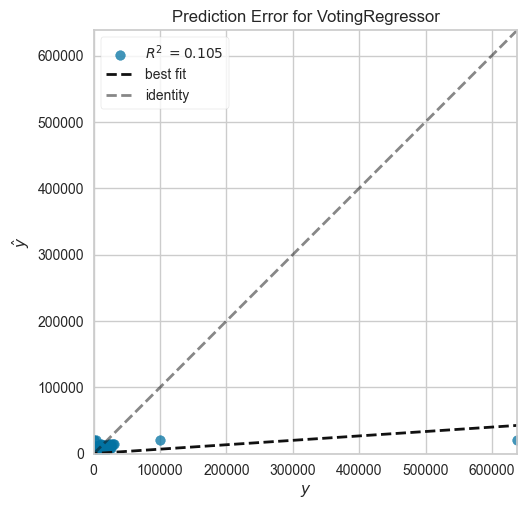

In [23]:
plot_model(ensemble_model, 'error')

# Experiment 6
Here, as we know the random Forest is the best algorithm based on experiment 2 we now remove from the 2019-2023 dataset all the instances greater than 35000 of installed power. From the prediction error chart of experiment 3 we had an insight that some outliers (i.e. instances with more than 35,000 of installed power) are responsible for high error prediction on the test set.

In [10]:
dataset_20192023_NoOutliers = dataset_20192023[dataset_20192023['Installed_power'] <= 35000]
len(dataset_20192023_NoOutliers)

76371

In [11]:
# Finding which are the outliers cities
original_dataset[original_dataset['Installed_power'] >= 35000]

,City_Cod,Quarter,Installed_power,Electricity Tariff,Demographic_density,Fleet,Average_minimum_wage,Number_employees,Number_companies,GDP,...,College education,Irradiance,Number of households,Cities verticalization,Households in rural area,Home ownership,Home rented,Residents per household,Households with 3 more salaries,City_Name
69032,4205407,2021Q4,41442.09,755.136416,765.4,378473,4.5,329451,32218,41388.53,...,0.175,4251,147437,0.3902,0.04,103062,38226,3.5,51658,Florianópolis
69033,4205407,2022Q1,53146.46,755.136416,765.4,378473,4.5,329451,32218,41388.53,...,0.175,4251,147437,0.3902,0.04,103062,38226,3.5,51658,Florianópolis
69034,4205407,2022Q2,100310.22,755.136416,765.4,378473,4.5,329451,32218,41388.53,...,0.175,4251,147437,0.3902,0.04,103062,38226,3.5,51658,Florianópolis
69035,4205407,2022Q3,638094.43,755.136416,765.4,378473,4.5,329451,32218,41388.53,...,0.175,4251,147437,0.3902,0.04,103062,38226,3.5,51658,Florianópolis


In [12]:
exp6 = setup(
    data = dataset_20192023_NoOutliers,
    target = 'Installed_power',
    fold_strategy = 'timeseries',
    session_id = 123,
    data_split_shuffle = False,
    fold=10,
    ignore_features = ['Quarter'], #once data has been sorted by quarter, we can ignore it
)

,Description,Value
0,Session id,123
1,Target,Installed_power
2,Target type,Regression
3,Original data shape,"(76371, 23)"
4,Transformed data shape,"(76371, 22)"
5,Transformed train set shape,"(53459, 22)"
6,Transformed test set shape,"(22912, 22)"
7,Ignore features,1
8,Numeric features,21
9,Preprocess,True


In [13]:
best6 = compare_models(turbo=False, exclude=['kr'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,112.9456,125705.8348,351.0059,0.6407,1.0721,2.1657,0.2780
rf,Random Forest Regressor,110.0108,124468.5268,350.1440,0.6386,1.0337,1.8909,10.5300
catboost,CatBoost Regressor,113.1605,128192.5755,355.0198,0.6267,1.0829,2.1596,3.9950
et,Extra Trees Regressor,111.8339,129685.5090,358.0924,0.6185,1.0899,1.7826,3.2600
xgboost,Extreme Gradient Boosting,114.4837,131728.5336,360.0004,0.6131,1.0930,2.1685,1.0400
knn,K Neighbors Regressor,114.9532,137574.4125,367.9605,0.5956,1.0577,1.8933,0.1880
gbr,Gradient Boosting Regressor,120.7715,149109.0038,379.8516,0.5944,1.1165,2.3662,2.3950
dt,Decision Tree Regressor,116.6989,141356.8026,372.8260,0.5825,1.1389,1.8329,0.1980
ada,AdaBoost Regressor,171.7516,187107.0791,425.3670,0.4919,1.5640,6.3118,0.3140
lr,Linear Regression,163.3828,244856.6702,482.0313,0.3654,1.4020,4.0302,0.7540


Processing:   0%|          | 0/105 [00:00<?, ?it/s]

In [17]:
model_lightgb = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,83.7722,69614.8679,263.8463,0.5004,1.1815,2.2319
1,105.9002,124819.4109,353.2979,0.4664,1.1207,2.0907
2,94.2913,87175.7016,295.2553,0.6416,1.1195,2.6194
3,88.3335,98814.6726,314.3480,0.5940,1.0991,2.3090
4,105.5127,144650.0747,380.3289,0.6194,1.0777,2.0824
5,141.1654,132781.5147,364.3920,0.6137,1.3107,3.4879
6,104.9526,98789.0866,314.3073,0.7178,1.0205,1.8605
7,123.2355,149497.8372,386.6495,0.7494,0.9443,1.4900
8,137.1993,181383.1365,425.8910,0.7365,0.9254,2.1552


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

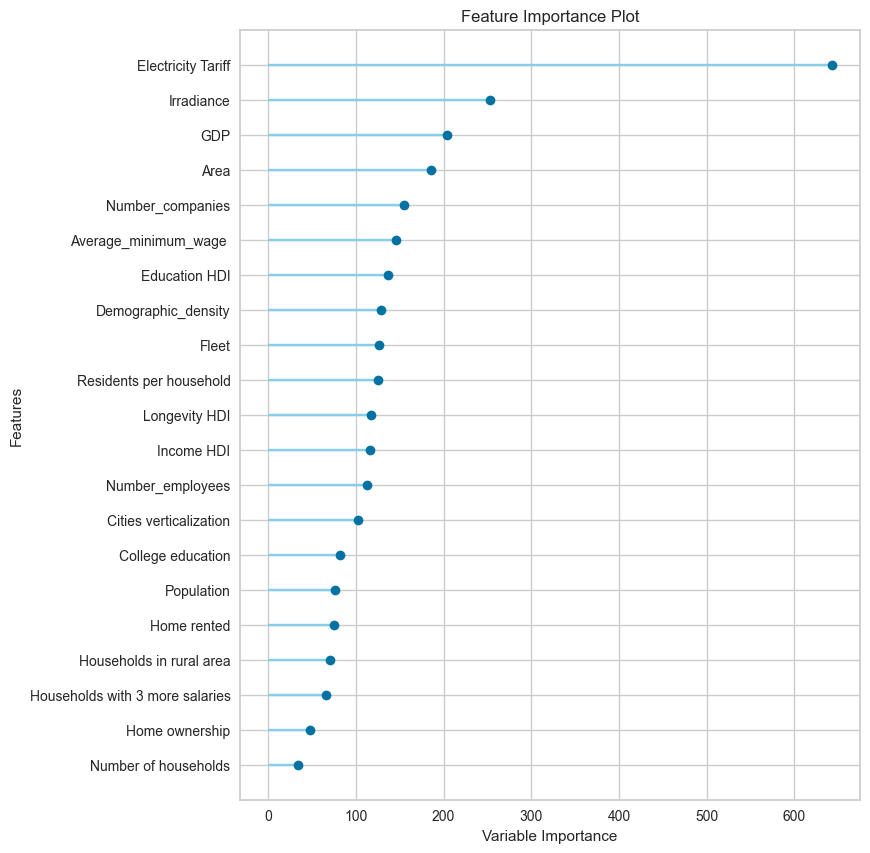

In [15]:
plot_model(model_lightgb, 'feature_all')

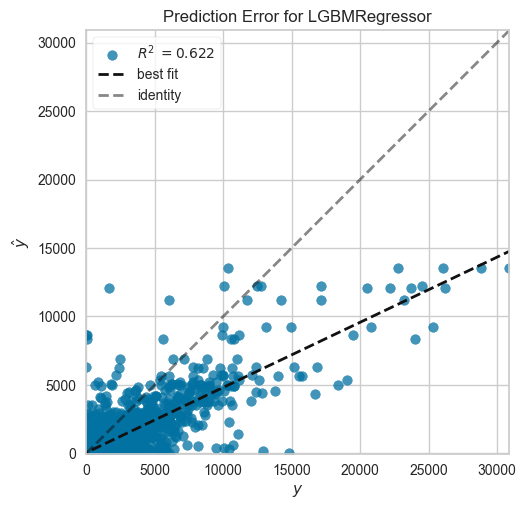

In [18]:
plot_model(model_lightgb, 'error')

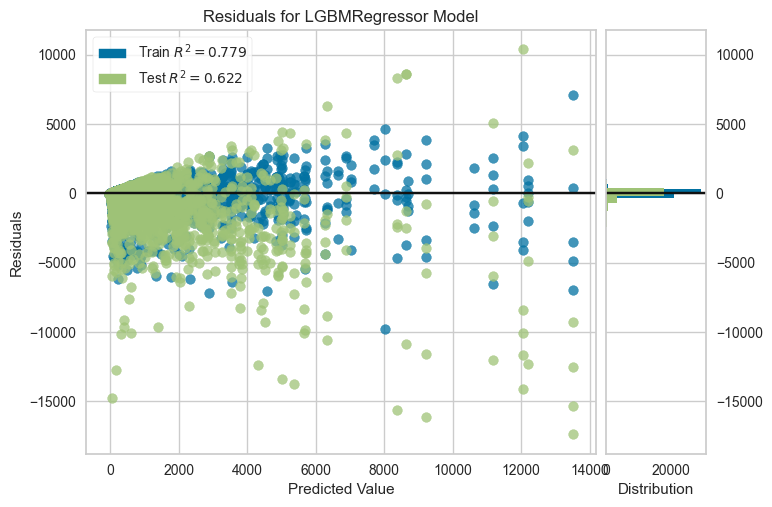

In [30]:
plot_model(model_lightgb, plot = 'residuals')

# Partial interpretation
As we can see above the best algorithm is light gradient boosting machine according R² value. However, Random Forest achieved lower RMSE and had a near R² value. Therefore, we decided to check the Random Forest result too.

In [19]:
model_rf = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,84.1743,72423.4477,269.1160,0.4802,1.1485,2.2952
1,107.2240,124428.1212,352.7437,0.4680,1.1389,2.1597
2,97.1503,94139.8127,306.8221,0.6129,1.1099,2.2776
3,89.5797,101452.0916,318.5154,0.5831,1.0760,2.0057
4,104.8650,143491.0730,378.8022,0.6225,1.0595,1.9305
5,124.8480,124568.1973,352.9422,0.6376,1.1131,2.5789
6,102.4633,105823.8504,325.3058,0.6977,0.9863,1.7038
7,120.8220,151479.1104,389.2032,0.7461,0.9228,1.3148
8,133.6274,175641.0470,419.0955,0.7449,0.9066,1.5842


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

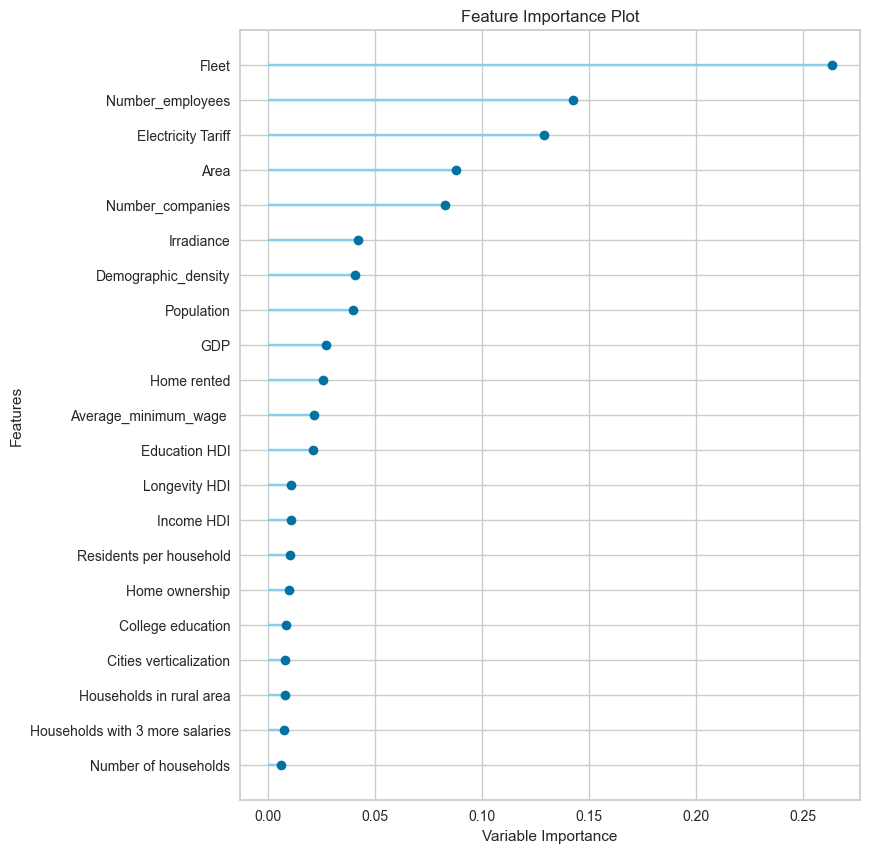

In [20]:
plot_model(model_rf, 'feature_all')

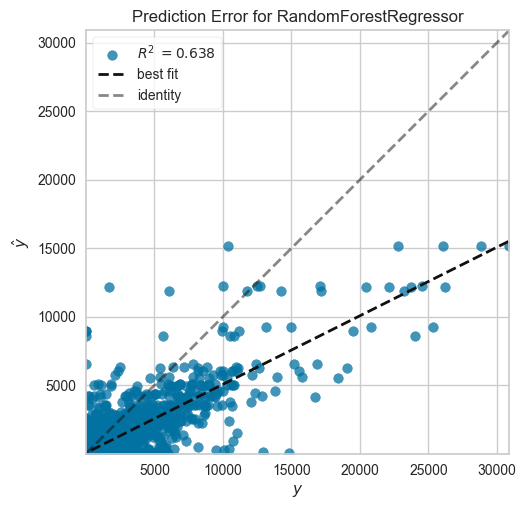

In [21]:
plot_model(model_rf, 'error')

# Conclusion
The experiment number six is the best. We consider the Light Gradient Boosting Machine superior than Random Forest because its greater R2 value, once it helps us to explain the predictors. Therefore, we selected the Light Gradient Boosting Machine features importance plot and its prediction error plot to discuss. 